In [ ]:
library(tidyverse)
library(midasr)
library(imputeTS)

In [2]:
# helper function, generate lagged datasets for testing on vintages
gen_lagged_data <- function (metadata, data, last_date, lag) {
  # only go up to the last date
  lagged_data <- data %>% 
    dplyr::filter(date <= last_date)
  
  for (col in colnames(lagged_data)[2:length(colnames(lagged_data))]) {
    pub_lag <- metadata %>% 
      dplyr::filter(series == col) %>% 
      select(months_lag) %>% 
      pull()
    
    # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back)
    condition <- (nrow(lagged_data) - pub_lag + lag)
    # only input NA if the lag is less than the latest row in the data
    if (condition <= nrow(lagged_data)) {
      lagged_data[condition:nrow(lagged_data), col] <- NA
    } 
  }
  lagged_data <- lagged_data %>% 
    dplyr::filter(!is.na(date))
  return (lagged_data)
}

# Data set up

In [ ]:
# full data read
metadata <- read_csv("../data/meta_data.csv")
data <- read_csv("../data/data_tf.csv") %>%
  arrange(date)

target_variable <- "gdpc1"

# which lags to assess
lags <- -2:2

# dates for training and test
# test set is shorter in this example notebook than in the paper to save runtime. Set test_start_date to "2002-03-01" and test_end_date to "2022-09-01" for results of the paper.
train_start_date <- "1947-01-01"
test_start_date <- "2005-03-01"
test_end_date <- "2010-03-01"

# will have a rolling test period, so model for e.g. 2002-03-01 is trained with data as it would have appeared on 2003-01-01, 2002-06-01 as it would have appeared on 2002-04-01, and so on. 
# This mimics the real-world nowcasting scenario
test_dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by = "3 months")

# test dataset
test <- data %>%
    dplyr::filter(date >= train_start_date, date <= test_end_date) %>%
    data.frame()

# replace any infinites with NA
for (col in colnames(test)) {
    if (sum(is.infinite(test[,col])) > 0) {
      test[is.infinite(test[,col]), col] <- NA 
    }
}

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
tail(data)

date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,⋯,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-08-01,0.001915508,NA,0.0011819650,0.002335260,0.18968692,0.006719933,0.05714286,0.09513435,-0.0006862216,⋯,-0.012295082,0.005672678,0.005504572,0.002682399,-0.08486647,-0.002056898,0.009037228,NA,-0.013707165,NA
2022-09-01,0.001761255,0.008011552,0.0038596847,0.002037679,-0.13467492,-0.001672780,-0.05405405,-0.02851459,0.0038251759,⋯,-0.010373444,0.005758545,0.004644000,0.003443036,0.01426719,0.002560770,0.002484690,0.005911377,-0.009475679,0.002056349
2022-10-01,0.001856197,NA,0.0043839992,0.007361543,0.08228980,0.013065747,0.05714286,-0.02116041,-0.0006249231,⋯,-0.004192872,0.002715462,0.002616225,0.003729239,-0.03324808,-0.001788585,0.002912884,NA,-0.003826531,NA
2022-11-01,0.001715758,NA,0.0009628869,-0.020892196,0.05785124,-0.005824232,0.00000000,-0.00488145,-0.0021948039,⋯,-0.006315789,0.001986837,0.001680901,0.001043196,-0.10648148,-0.003270767,NA,NA,-0.002560819,NA
2022-12-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2023-01-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Training the model

The model is trained on a rolling basis. So if we are predicting 2000-03-01, the model is trained on data as it would have appeared in 1999-12-01, right before the beginning of the prediction period.

# Testing the model on artificial data vintages

In [5]:
# dataframe for predictions
pred_dict <- data.frame(date = test_dates)
for (lag in lags) {
  pred_dict[,as.character(lag)] <- NA
}

In [6]:
# looping through test dates
for (i in 1:length(test_dates)) {
    # training the actual model
    train <- test %>%
        dplyr::filter(date <= seq(as.Date(test_dates[i]), by="-3 months", length=2)[2]) %>% # data as it would have appeared at beginning of prediction period
        na_mean()

    # estimating MIDAS models
    y <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"),  target_variable]
    models <- list()

    # for MIDAS, a separate model is trained for each explanatory variable
    for (col in colnames(train)[2:ncol(train)]) {
        if (col != target_variable) {
            if (col %in% c("ulcnfb", "a261rx1q020sbea")) { # quarterly variables
                x <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"), col]
                models[[col]] <- midas_r(y ~ mls(x, 0:1, 1, nealmon), start=list(x=c(1, -0.5)))
            } else { # monthly variables, the mls() function handles lagging and flattening the data
                x <- train[,col]
                models[[col]] <- midas_r(y ~ mls(x, 0:3, 3, nealmon), start=list(x=c(1, -0.5)))
            } 
        }
    }

    # some variables have more predictive power than others, a straight average weighting would give too much weight to those unhelpful variables
    # RMSE for weighting based on fit on the training set gives much better results
    weight <- list()
    for (col in colnames(train)[2:ncol(train)]) {
        if (col != target_variable) {
            fitted <- models[[col]]$fitted.values
            actual <- y[2:length(y)]
            weight[[col]] <- (fitted - actual)**2 %>% mean() %>% sqrt()
        }
    }
    # discount the least predictive variable
    adj <- abs(unlist(weight) - max(unlist(weight)))
    weight <- (adj / sum(adj))
    
   
    # testing the model on artificial vintages  
    for (lag in lags) {
        lagged_data <- gen_lagged_data(metadata, test, test_dates[i], lag) %>% 
          data.frame
        # make sure actual value not in there
        lagged_data[lagged_data$date == test_dates[i], target_variable] <- NA
        lagged_data <- na_mean(lagged_data) # fill missing with mean to get estimate

        y <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"),  target_variable]
        preds <- list()

        # loop through all the individual models to get predictions, later will weighted average them
        for (col in colnames(test)[2:ncol(test)]) {
            if (col != target_variable) {
              if (col %in% c("ulcnfb", "a261rx1q020sbea")) { # quarterly variables
                x <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), col]
                preds[[col]] <- forecast(models[[col]], newdata=list(x=x))$mean
                preds[[col]] <- preds[[col]][length(preds[[col]])]
              } else { # monthly variables
                x <- lagged_data[,col]
                preds[[col]] <- forecast(models[[col]], newdata=list(x=x))$mean
                preds[[col]] <- preds[[col]][length(preds[[col]])]
              } 
            }
        }
        # averaged predictions
        pred_dict[pred_dict$date == test_dates[i], as.character(lag)] <- weighted.mean(unlist(preds), weight)
    }
}

# Assess and visualize model performance

In [7]:
actuals <- test %>%
    filter(date >= test_start_date) %>%
    filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>%
    select(!!target_variable) %>%
    pull()

In [8]:
performance <- data.frame(Vintage = numeric(), RMSE = numeric())
for (lag in lags) {
    tmp = data.frame(
        Vintage = lag,
        RMSE = sqrt(mean((actuals - pred_dict[,as.character(lag)])**2))
    )
    performance = rbind(performance, tmp)
}
round(performance, 4)

Vintage,RMSE
<dbl>,<dbl>
-2,0.0081
-1,0.0073
0,0.0067
1,0.0059
2,0.0041


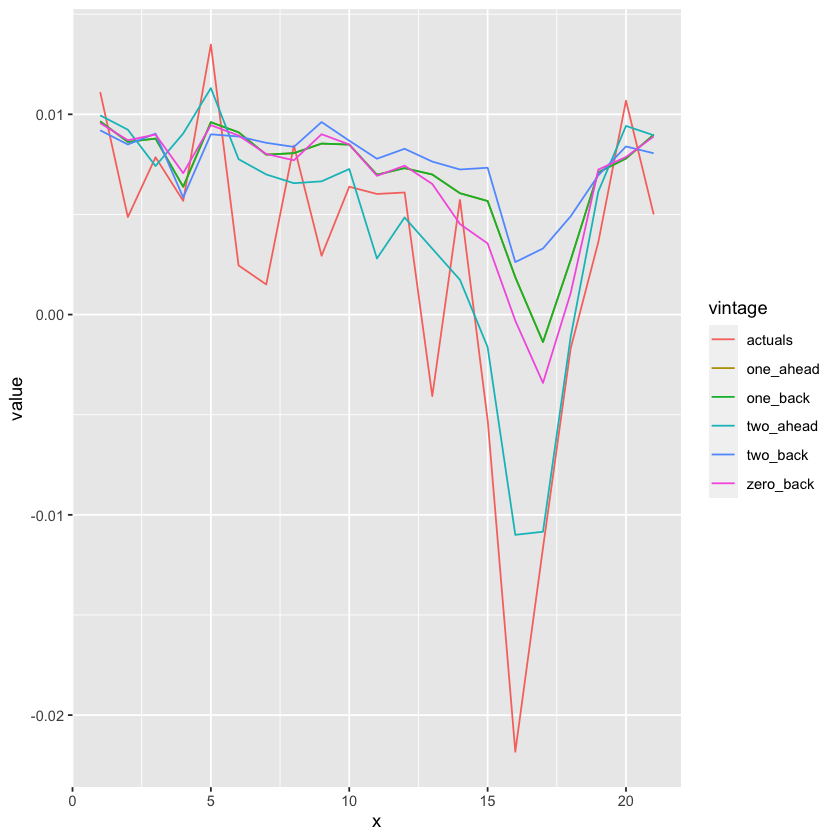

In [9]:
# plot of predictions vs actuals
p <- tibble(
    actuals = actuals,
    two_back = pred_dict[, "-2"], 
    one_back = pred_dict[, "-1"], 
    zero_back = pred_dict[, "0"],
    one_ahead = pred_dict[, "-1"],
    two_ahead = pred_dict[, "2"]
) %>%
    mutate(x = 1:n()) %>%
    gather(vintage, value, -x) %>%
    ggplot() + 
    aes(x=x, y=value, color=vintage) + 
    geom_line()
p

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [10]:
# the test data ends 2010-03-01, let's say we wanted to predict 2010-06-01
new_data = test

# the date we want predicted must be in the date, if it's not there it must be added
desired_date <- "2010-06-01"
months_to_add <- seq(max(new_data$date), as.Date(desired_date), by="month") %>% as.character()

for (value in months_to_add[2:length(months_to_add)]) {
    new_data[nrow(new_data) + 1, "date"] <- value
}

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data %>% tail()

# fill missings
new_data <- new_data %>% na_mean()

,date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,⋯,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
757,2010-01-01,1.540975e-05,NA,0.0006487322,0.127685024,-0.01988636,-8.379759e-05,-0.01010101,0.05679862,0.010900832,⋯,0.0120578778,-0.0011227765,0.0014678326,2.186252e-03,-0.04216867,0.012824908,0.001697060,NA,0.008354219,NA
758,2010-02-01,-7.088374e-04,NA,-0.0009517766,-0.003126795,-0.02608696,2.288733e-03,0.00000000,-0.01628664,0.003535007,⋯,-0.0007942812,0.0004441765,0.0008731718,-3.146369e-05,0.02201258,0.005553038,0.006594576,NA,-0.003314002,NA
759,2010-03-01,1.395550e-03,0.005000535,0.0003313681,0.009409809,0.13392857,2.169620e-02,0.01020408,0.05298013,0.007105439,⋯,0.0039745628,0.0002355809,0.0014955601,1.415911e-03,0.05692308,0.009229304,0.004449005,-0.01190992,0.007481297,0.005756856
760,2010-04-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
761,2010-05-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
762,2010-06-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [11]:
# training the actual model
train <- new_data %>%
    na_mean()

# estimating MIDAS models
y <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"),  target_variable]
models <- list()

# for MIDAS, a separate model is trained for each explanatory variable
for (col in colnames(train)[2:ncol(train)]) {
    if (col != target_variable) {
        if (col %in% c("ulcnfb", "a261rx1q020sbea")) { # quarterly variables
            x <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"), col]
            models[[col]] <- midas_r(y ~ mls(x, 0:1, 1, nealmon), start=list(x=c(1, -0.5)))
        } else { # monthly variables, the mls() function handles lagging and flattening the data
            x <- train[,col]
            models[[col]] <- midas_r(y ~ mls(x, 0:3, 3, nealmon), start=list(x=c(1, -0.5)))
        } 
    }
}

# some variables have more predictive power than others, a straight average weighting would give too much weight to those unhelpful variables
# RMSE for weighting based on fit on the training set gives much better results
weight <- list()
for (col in colnames(train)[2:ncol(train)]) {
    if (col != target_variable) {
        fitted <- models[[col]]$fitted.values
        actual <- y[2:length(y)]
        weight[[col]] <- (fitted - actual)**2 %>% mean() %>% sqrt()
    }
}
# discount the least predictive variable
adj <- abs(unlist(weight) - max(unlist(weight)))
weight <- (adj / sum(adj))

In [12]:
# loop through all the individual models to get predictions, later will weighted average them
preds <- list()
for (col in colnames(new_data)[2:ncol(new_data)]) {
    if (col != target_variable) {
      if (col %in% c("ulcnfb", "a261rx1q020sbea")) { # quarterly variables
        x <- new_data[substr(new_data$date, 6, 7) %in% c("03", "06", "09", "12"), col]
        preds[[col]] <- forecast(models[[col]], newdata=list(x=x))$mean
        # the `forecast` function from midasr produces predictions for all periods in the data
        # we're interested in the last one, for 2010-06-01
        preds[[col]] <- preds[[col]][length(preds[[col]])]
      } else { # monthly variables
        x <- new_data[,col]
        preds[[col]] <- forecast(models[[col]], newdata=list(x=x))$mean
        preds[[col]] <- preds[[col]][length(preds[[col]])]
      } 
    }
}
# averaged predictions
weighted.mean(unlist(preds), weight)

[1] 0.0088176